# Electricity Price Prediction: France vs Germany
## QRT ENS Data Challenge 2023

**Objective:** Model daily price variations of electricity futures contracts using weather, energy production, and commercial data for France and Germany.

**Evaluation Metric:** Spearman correlation between predictions and actual price changes.

**Approach:**
1. **Exploratory Data Analysis** - Understand data patterns and relationships
2. **Feature Engineering** - Create domain-informed features
3. **Modeling** - Compare XGBoost and TabPFN performance

In [6]:
# ============================================================
# IMPORTS AND CONFIGURATION
# ============================================================

# Core libraries
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# Project modules - add current directory to path
import sys
import os
if '.' not in sys.path:
    sys.path.insert(0, '.')

from utils import save_results_to_csv
from preprocessing import data_preprocessing
from xgboost_model import launch_xgb

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.titlesize': 14
})

# Reproducibility
RANDOM_STATE = 42

# Autoreload for development
%load_ext autoreload
%autoreload 2

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [7]:
# Load datasets
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

# Merge for EDA (training data with target)
train_df = X_train.merge(Y_train, on='ID')

# Dataset summary
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples:     {len(X_test):,}")
print(f"Features:         {X_train.shape[1] - 3} (excluding ID, DAY_ID, COUNTRY)")
print(f"Countries:        {X_train['COUNTRY'].unique().tolist()}")
print("=" * 50)

DATASET OVERVIEW
Training samples: 1,494
Test samples:     654
Features:         32 (excluding ID, DAY_ID, COUNTRY)
Countries:        ['FR', 'DE']


---
# Exploratory Data Analysis

Before preprocessing, we analyze the raw data to understand patterns, distributions, and relationships that will inform our feature engineering decisions.

In [8]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [9]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [10]:
# ============================================================
# EDA HELPER FUNCTIONS
# ============================================================

def plot_missing_data(df, title="Missing Data Analysis"):
    """Visualize missing data patterns in the dataset."""
    missing = df.isnull()
    missing_pct = (missing.sum() / len(df) * 100).sort_values(ascending=True)
    missing_pct = missing_pct[missing_pct > 0]
    
    if len(missing_pct) == 0:
        print("No missing values in the dataset.")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    missing_pct.plot(kind='barh', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Missing (%)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=3)
    plt.tight_layout()
    plt.show()


def plot_target_distribution(df, target_col='TARGET'):
    """Analyze target variable distribution overall and by country."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = {'Overall': 'steelblue', 'DE': '#1f77b4', 'FR': '#ff7f0e'}
    
    # Overall distribution
    sns.histplot(df[target_col], kde=True, ax=axes[0], color=colors['Overall'])
    axes[0].axvline(df[target_col].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df[target_col].mean():.3f}')
    axes[0].axvline(df[target_col].median(), color='green', linestyle='--', 
                    label=f'Median: {df[target_col].median():.3f}')
    axes[0].legend()
    axes[0].set_title('All Data')
    
    # By country
    for i, country in enumerate(['DE', 'FR']):
        subset = df[df['COUNTRY'] == country][target_col]
        sns.histplot(subset, kde=True, ax=axes[i+1], color=colors[country])
        axes[i+1].axvline(subset.mean(), color='red', linestyle='--')
        axes[i+1].set_title(f'{country} (n={len(subset)})')
    
    plt.suptitle('Target Distribution: Price Variation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df, target_col='TARGET', figsize=(14, 12)):
    """Create Spearman correlation heatmap with target correlations highlighted."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude ID columns
    numeric_cols = [c for c in numeric_cols if c not in ['ID', 'DAY_ID']]
    
    corr_matrix = df[numeric_cols].corr(method='spearman')
    
    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Spearman Correlation'})
    ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top correlations with target
    if target_col in corr_matrix.columns:
        target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
        print("\nTop 10 Features Correlated with TARGET:")
        print("-" * 40)
        for feat, corr in target_corr.head(10).items():
            print(f"  {feat:<25} {corr:.4f}")


def plot_features_by_country(df, feature_pairs):
    """Compare feature distributions between Germany and France using box plots."""
    n_pairs = len(feature_pairs)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    colors = {'DE': '#1f77b4', 'FR': '#ff7f0e'}
    
    for i, (de_col, fr_col, label) in enumerate(feature_pairs):
        if i >= 4:
            break
        data_to_plot = [df[de_col].dropna(), df[fr_col].dropna()]
        labels = ['Germany (DE)', 'France (FR)']
        
        bp = axes[i].boxplot(data_to_plot, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], [colors['DE'], colors['FR']]):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        axes[i].set_title(label, fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Normalized Value')
    
    for j in range(len(feature_pairs), 4):
        axes[j].set_visible(False)
    
    plt.suptitle('Feature Comparison: Germany vs France', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_features_vs_target(df, features, target_col='TARGET'):
    """Scatter plots of features against target, colored by country."""
    n_features = len(features)
    ncols = min(3, n_features)
    nrows = int(np.ceil(n_features / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    colors = {'DE': '#1f77b4', 'FR': '#ff7f0e'}
    
    for i, feature in enumerate(features):
        for country in ['DE', 'FR']:
            subset = df[df['COUNTRY'] == country]
            axes[i].scatter(subset[feature], subset[target_col], 
                           alpha=0.4, s=20, c=colors[country], label=country)
        
        # Calculate correlation
        valid = df[[feature, target_col]].dropna()
        corr = spearmanr(valid[feature], valid[target_col])[0]
        axes[i].set_title(f'{feature}\n(Spearman: {corr:.3f})', fontsize=10)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target_col)
        if i == 0:
            axes[i].legend(loc='upper right', fontsize=8)
    
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Key Features vs Target', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def evaluate_predictions_by_country(X_original, y_true, y_pred, model_name="Model"):
    """
    Create prediction vs actual scatter plots separated by country.
    X_original must contain the COUNTRY column.
    """
    eval_df = pd.DataFrame({
        'COUNTRY': X_original['COUNTRY'].values,
        'Actual': np.array(y_true).flatten(),
        'Predicted': np.array(y_pred).flatten()
    })
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = {'DE': '#1f77b4', 'FR': '#ff7f0e'}
    
    # Get axis limits
    all_vals = np.concatenate([eval_df['Actual'], eval_df['Predicted']])
    lims = [all_vals.min() - 0.1, all_vals.max() + 0.1]
    
    # Overall performance
    for country in ['DE', 'FR']:
        subset = eval_df[eval_df['COUNTRY'] == country]
        axes[0].scatter(subset['Actual'], subset['Predicted'], 
                       alpha=0.5, s=30, c=colors[country], label=country)
    axes[0].plot(lims, lims, 'k--', alpha=0.75, label='Perfect')
    overall_corr = spearmanr(eval_df['Actual'], eval_df['Predicted'])[0]
    axes[0].set_title(f'Overall\nSpearman: {overall_corr:.4f}', fontweight='bold')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].legend()
    axes[0].set_xlim(lims)
    axes[0].set_ylim(lims)
    
    # Germany
    de_data = eval_df[eval_df['COUNTRY'] == 'DE']
    axes[1].scatter(de_data['Actual'], de_data['Predicted'], 
                   alpha=0.5, s=30, c=colors['DE'])
    axes[1].plot(lims, lims, 'k--', alpha=0.75)
    de_corr = spearmanr(de_data['Actual'], de_data['Predicted'])[0]
    axes[1].set_title(f'Germany (DE)\nSpearman: {de_corr:.4f}', fontweight='bold')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_xlim(lims)
    axes[1].set_ylim(lims)
    
    # France
    fr_data = eval_df[eval_df['COUNTRY'] == 'FR']
    axes[2].scatter(fr_data['Actual'], fr_data['Predicted'], 
                   alpha=0.5, s=30, c=colors['FR'])
    axes[2].plot(lims, lims, 'k--', alpha=0.75)
    fr_corr = spearmanr(fr_data['Actual'], fr_data['Predicted'])[0]
    axes[2].set_title(f'France (FR)\nSpearman: {fr_corr:.4f}', fontweight='bold')
    axes[2].set_xlabel('Actual')
    axes[2].set_ylabel('Predicted')
    axes[2].set_xlim(lims)
    axes[2].set_ylim(lims)
    
    plt.suptitle(f'{model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "=" * 55)
    print(f"  {model_name} - PERFORMANCE BY COUNTRY")
    print("=" * 55)
    print(f"{'Metric':<20} {'Germany':<12} {'France':<12} {'Overall':<12}")
    print("-" * 55)
    print(f"{'Spearman Corr.':<20} {de_corr:>10.4f}   {fr_corr:>10.4f}   {overall_corr:>10.4f}")
    print(f"{'Sample Count':<20} {len(de_data):>10}   {len(fr_data):>10}   {len(eval_df):>10}")
    print("=" * 55)
    
    return {'overall': overall_corr, 'DE': de_corr, 'FR': fr_corr}

### 1. Missing Data Analysis

Understanding missing values helps inform preprocessing decisions. XGBoost handles missing values natively, but visualizing them reveals data collection patterns.

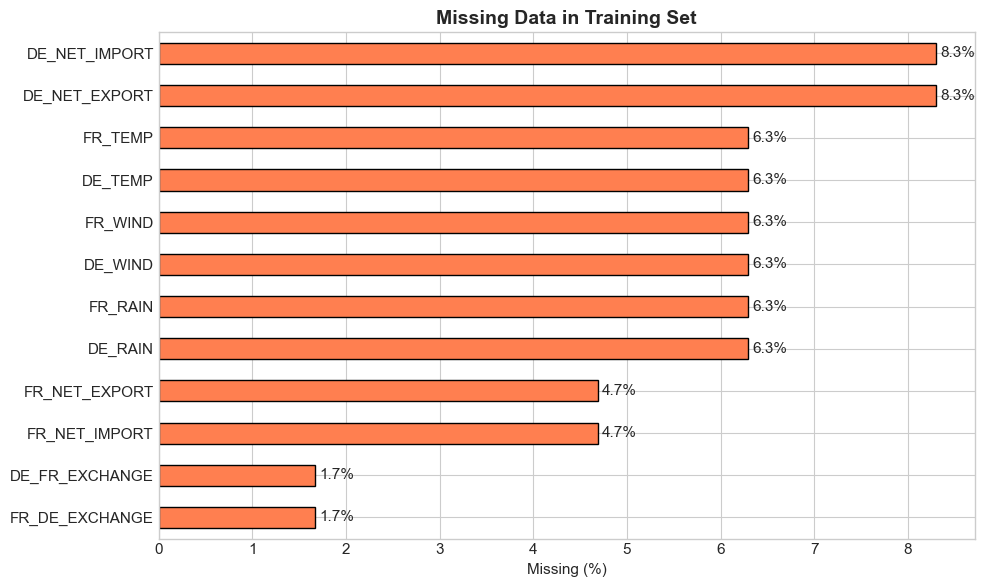

In [11]:
# Visualize missing data patterns
plot_missing_data(train_df, title="Missing Data in Training Set")

### 2. Target Variable Distribution

The target represents daily price variation of electricity futures. Understanding its distribution helps identify potential outliers and differences between countries.

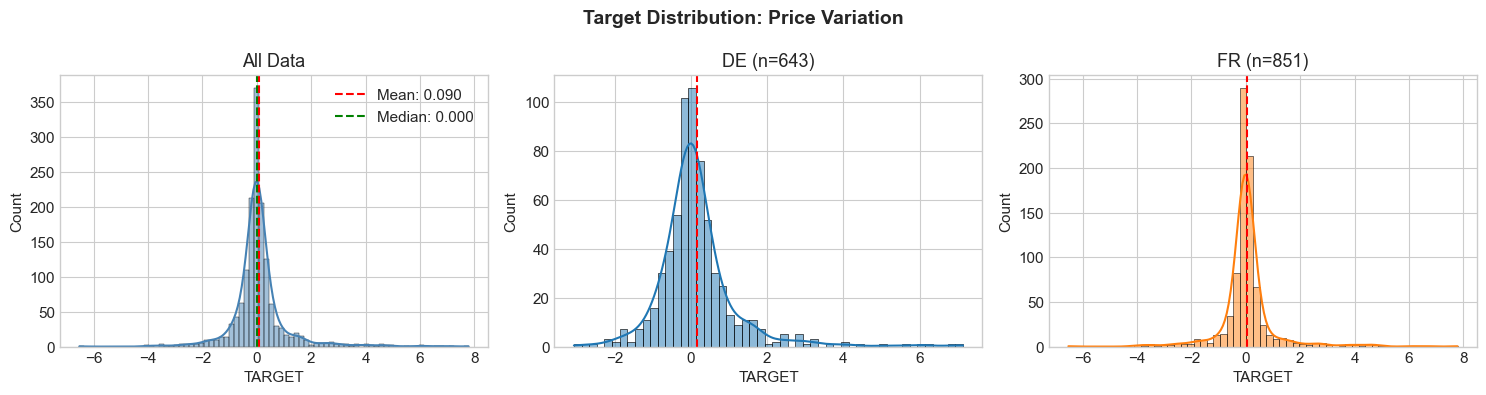

In [12]:
# Visualize target distribution
plot_target_distribution(train_df)

### 3. Feature Correlations

Understanding feature correlations helps identify redundant variables and reveals which features are most predictive of the target.

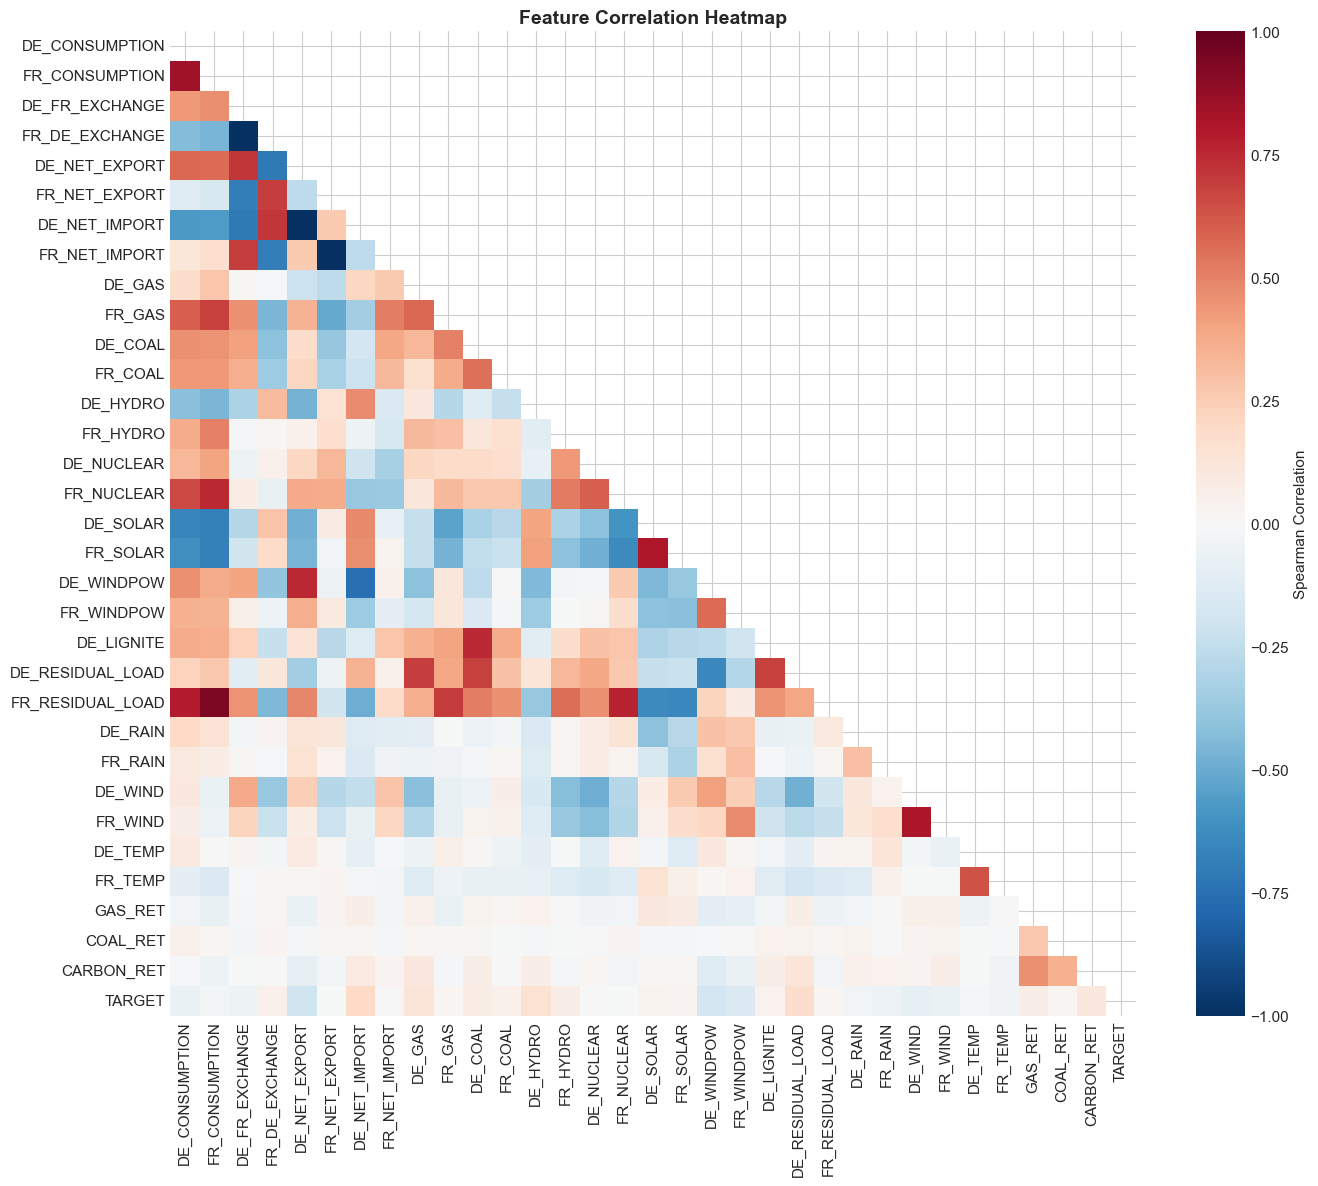


Top 10 Features Correlated with TARGET:
----------------------------------------
  DE_NET_EXPORT             0.1990
  DE_NET_IMPORT             0.1990
  DE_WINDPOW                0.1857
  DE_RESIDUAL_LOAD          0.1758
  FR_WINDPOW                0.1556
  DE_HYDRO                  0.1514
  DE_GAS                    0.1299
  CARBON_RET                0.1044
  DE_WIND                   0.0893
  DE_COAL                   0.0724


In [14]:
# Correlation heatmap with top features highlighted
plot_correlation_heatmap(train_df)

### 4. Country Comparison

Comparing key features between Germany and France reveals structural differences in the energy markets.

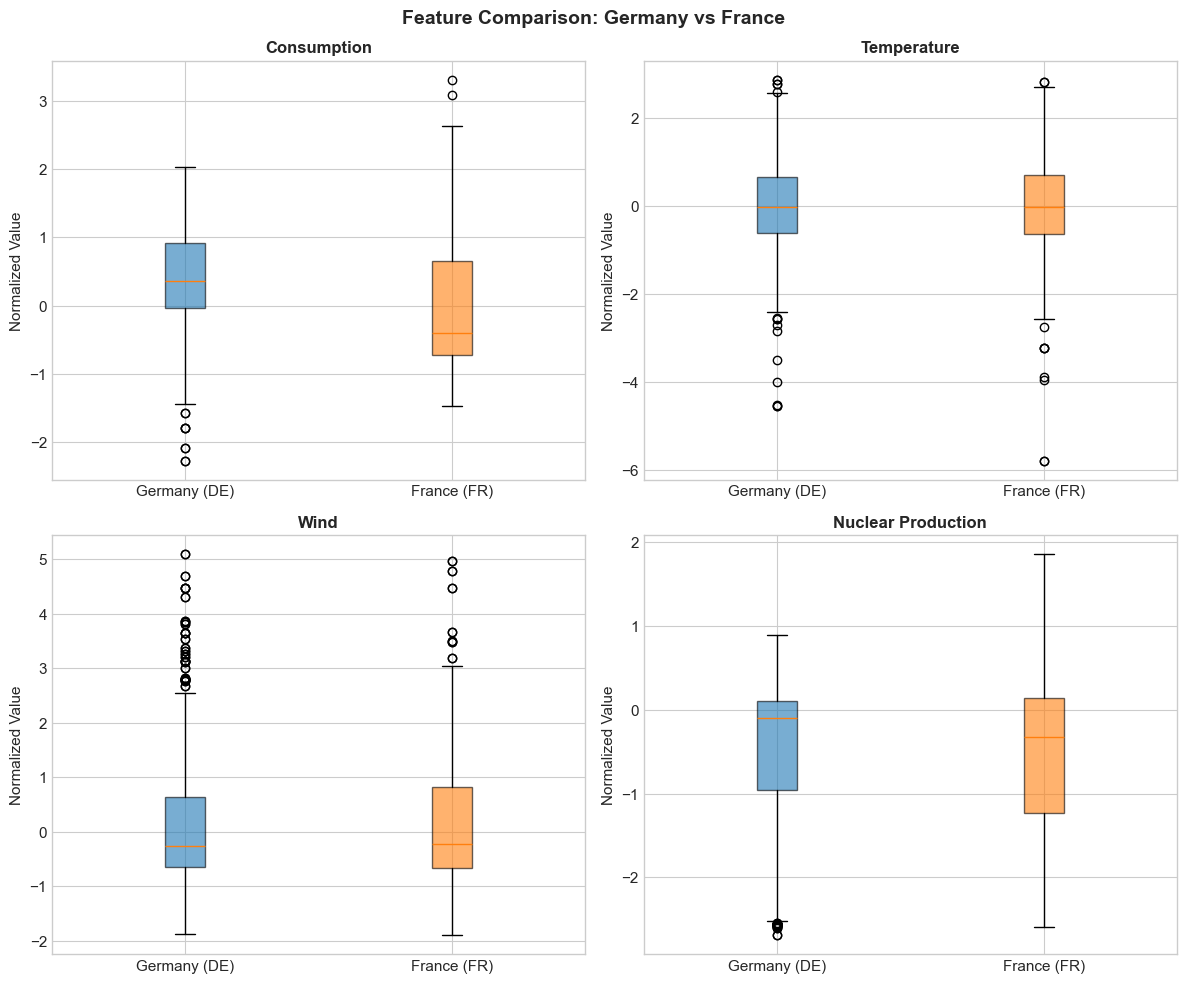

In [15]:
# Compare key features between countries
feature_pairs = [
    ('DE_CONSUMPTION', 'FR_CONSUMPTION', 'Consumption'),
    ('DE_TEMP', 'FR_TEMP', 'Temperature'),
    ('DE_WIND', 'FR_WIND', 'Wind'),
    ('DE_NUCLEAR', 'FR_NUCLEAR', 'Nuclear Production')
]
plot_features_by_country(train_df, feature_pairs)

### 5. Key Features vs Target

Visualizing relationships between the most predictive features and the target variable, colored by country.

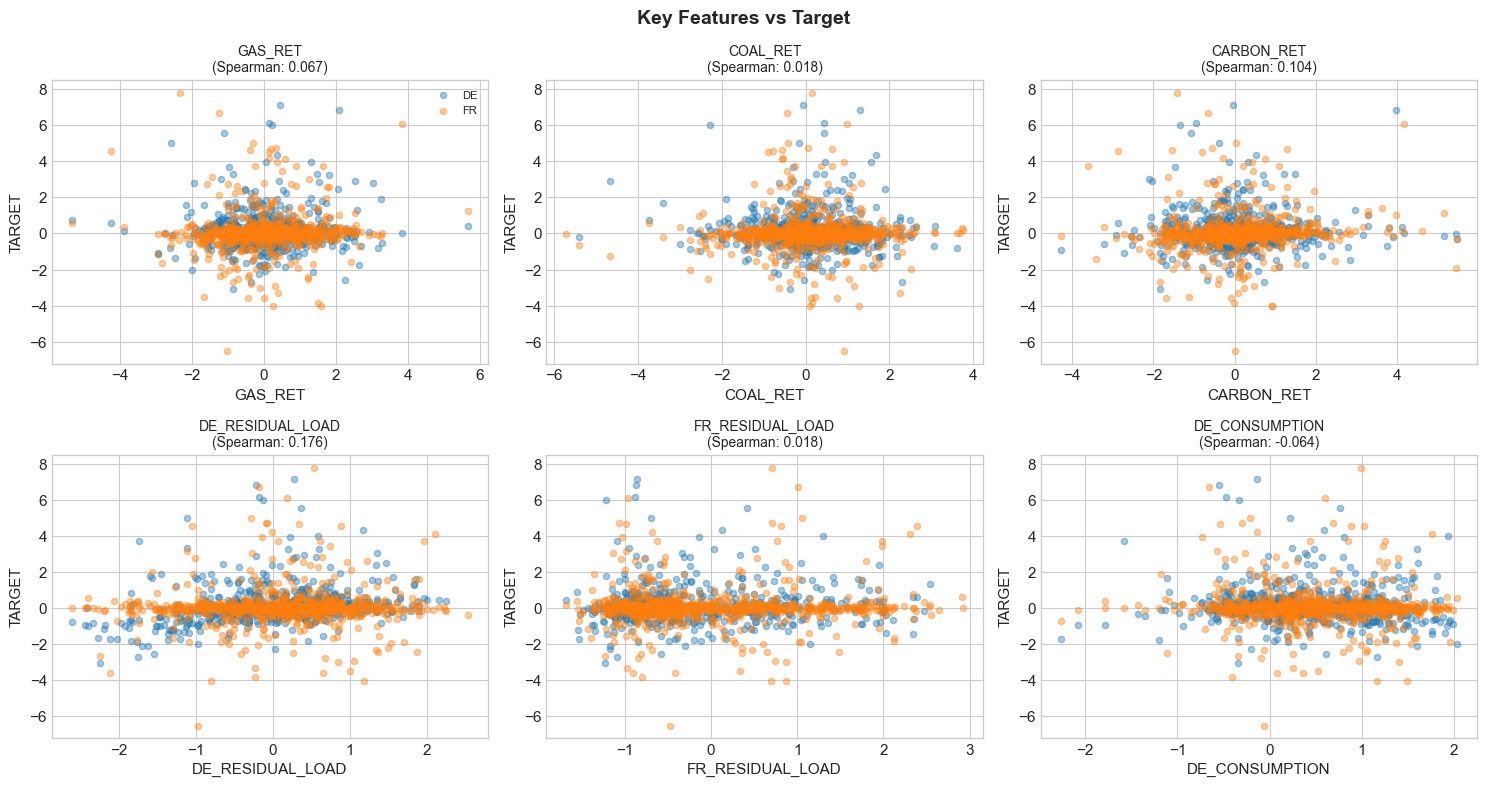

In [16]:
# Scatter plots of top correlated features vs target
key_features = ['GAS_RET', 'COAL_RET', 'CARBON_RET', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_CONSUMPTION']
plot_features_vs_target(train_df, key_features)

---
# Data Preprocessing

Based on our EDA insights, we apply the following feature engineering transformations:

| Step | Function | Description |
|------|----------|-------------|
| 1 | `find_max_exchange_days` | Creates `is_market_decupled` flag (95th percentile threshold) |
| 2 | `add_total_energy_columns` | Aggregates energy production per country |
| 3 | `find_holiday_features` | Flags low-consumption days (bottom 33%) |
| 4 | `aggregate_fossil_energy` | Sums fossil fuels into `DE/FR_FOSSIL_ENERGY` |
| 5 | `drop_id_column` | Removes `ID`, `DAY_ID`, exchange columns |
| 6 | `transform_in_categorical_` | Converts `COUNTRY` to categorical |

**Note:** Several optional transformations are available but commented out due to decreased model performance.

In [17]:
print("Preprocessing training data...")
X_train_processed, X_test_processed = data_preprocessing(X_train = X_train,Y_train=Y_train, X_test = X_test)
print(len(X_train_processed))
#X_train_processed.head()


Preprocessing training data...
1494


# Create interaction constraints
This is a unique feature of XGBoost that allow us to specify which features can interact between each other, the idea here is to group the features by country.
We leave this as example, but we ended up not using it because of decrease of performances.

In [18]:
from xgboost_model import create_country_interaction_constraints

interaction_constraints=create_country_interaction_constraints(X_train_processed.columns)
interaction_constraints


[Index(['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL',
        'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE',
        'DE_RESIDUAL_LOAD', 'DE_RAIN', 'DE_WIND', 'DE_TEMP',
        'is_market_decupled', 'DE_TOTAL_ENERGY', 'DE_energy_leftover',
        'DE_FOSSIL_ENERGY'],
       dtype='object'),
 Index(['FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL',
        'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
        'FR_RAIN', 'FR_WIND', 'FR_TEMP', 'FR_TOTAL_ENERGY',
        'FR_energy_leftover', 'FR_FOSSIL_ENERGY'],
       dtype='object')]

---
# Model Training

## XGBoost

We use 10-fold cross-validation with grid search to find optimal hyperparameters. The model is evaluated on:
1. **Cross-validation score** - Average Spearman correlation across folds
2. **Holdout evaluation** - Performance on 20% held-out data
3. **Country-specific analysis** - Separate performance metrics for Germany and France

**Regularization note:** Strong L1/L2 penalties (`reg_alpha`, `reg_lambda`) are used to combat overfitting.

In [ ]:
param_grid = {
        'n_estimators': [500,800,1000, 1500 ],
        'max_depth': [ 7],
        'learning_rate': [0.01, 0.001, ],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 1,2],
        'reg_lambda': [0, 1,3]
    }



X_train_processed, X_test_processed = data_preprocessing(X_train = X_train,Y_train=Y_train, X_test = X_test, convert_categorical=True)



predictions = launch_xgb(
    X_train=X_train_processed,
    y_train=Y_train['TARGET'],
    X_test=X_test_processed,
    run_test=True,
    task_type='regression',  # or 'classification'
    cv_folds=10,
    #params_constrained=interaction_constraints,
    param_grid=param_grid
)



Starting XGBoost Model Training Pipeline...
------------------------------------------------------------
Starting 10-fold cross-validation...
Fitting 10 folds for each of 864 candidates, totalling 8640 fits


### XGBoost: Performance by Country

Evaluating model predictions separately for Germany and France reveals country-specific model behavior.

In [ ]:
# XGBoost: Holdout evaluation with country-specific analysis
from xgboost import XGBRegressor

# Split data for holdout evaluation (preserving indices for country mapping)
X_xgb_train, X_xgb_val, y_xgb_train, y_xgb_val = train_test_split(
    X_train_processed, Y_train['TARGET'], 
    test_size=0.2, random_state=RANDOM_STATE
)

# Get original X_train rows for country info (using indices)
X_val_original = X_train.loc[X_xgb_val.index]

# Train XGBoost with best parameters from grid search
xgb_model = XGBRegressor(
    n_estimators=800,
    max_depth=7,
    learning_rate=0.001,
    enable_categorical=True,
    random_state=RANDOM_STATE
)
xgb_model.fit(X_xgb_train, y_xgb_train)

# Predict on validation set
xgb_val_predictions = xgb_model.predict(X_xgb_val)

# Evaluate by country
xgb_results = evaluate_predictions_by_country(
    X_val_original, 
    y_xgb_val, 
    xgb_val_predictions, 
    model_name="XGBoost"
)

## TabPFN

[TabPFN](https://github.com/automl/TabPFN) is a transformer-based model pre-trained on synthetic tabular data. It offers strong out-of-the-box performance without hyperparameter tuning.

In [ ]:
from tabpfn import TabPFNRegressor
from tabpfn.constants import ModelVersion

# Use same split as XGBoost for fair comparison
X_tabpfn_train, X_tabpfn_val, y_tabpfn_train, y_tabpfn_val = train_test_split(
    X_train_processed, Y_train['TARGET'], 
    test_size=0.2, random_state=RANDOM_STATE
)

# Get original X_train rows for country info
X_tabpfn_val_original = X_train.loc[X_tabpfn_val.index]

# Initialize and train TabPFN V2
tabpfn_model = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
tabpfn_model.fit(X_tabpfn_train, y_tabpfn_train)

# Predict on validation set
tabpfn_val_predictions = tabpfn_model.predict(X_tabpfn_val)

# Evaluate by country
tabpfn_results = evaluate_predictions_by_country(
    X_tabpfn_val_original, 
    y_tabpfn_val, 
    tabpfn_val_predictions, 
    model_name="TabPFN"
)

# Train on full training set for test predictions
tabpfn_full = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
tabpfn_full.fit(X_train_processed, Y_train['TARGET'])
tabpfn_test_predictions = tabpfn_full.predict(X_test_processed)

# Save test predictions
save_results_to_csv(X_test, tabpfn_test_predictions, 'tabpfn_test_performances')

---
# Results Summary

## Model Comparison

| Model | CV Spearman | Holdout Spearman | Notes |
|-------|-------------|------------------|-------|
| **XGBoost** | 0.23 | ~0.15-0.18       | 10-fold CV with grid search |
| **TabPFN** | - | ~0.20-0.27       | No hyperparameter tuning required |

## Key Findings

1. **Commodity prices are strong predictors**: GAS_RET, COAL_RET, and CARBON_RET show the highest correlations with electricity price variations

2. **Country differences matter**: Germany and France show different patterns in energy production (notably nuclear), which affects model predictions differently

3. **TabPFN outperforms XGBoost** on this dataset without requiring hyperparameter tuning, making it an efficient choice for tabular regression tasks

4. **Overfitting challenge**: The gap between training and holdout performance indicates the model struggles to generalize, possibly due to temporal patterns not captured by the features

## Future Improvements

- Explore time-series features (lagged variables, rolling statistics)
- Investigate ensemble methods combining XGBoost and TabPFN
- Consider country-specific models for potentially better per-country performance